<h1>
  <hr style="border:none; height:3px;">
  <center>Semi-Supervised Learning</center>
  <hr style="border:none; height:3px;">
</h1>

# Introduction

In this project, we observed that many properties related to welding quality have only a small portion of labeled data. The properties and the number of labeled instances for each are listed below:


<div style="display: flex; justify-content: center;">

<table style="border-collapse: collapse; text-align: center;">
    <tr>
        <th style="padding: 10px; border: 1px solid white;">Property</th>
        <th style="padding: 10px; border: 1px solid white;">Labeled Instances (non-null values)</th>
    </tr>
    <tr>
        <td style="padding: 10px; border: 1px solid white;">Hardness (kgmm-2)</td>
        <td style="padding: 10px; border: 1px solid white;">138</td>
    </tr>
    <tr>
        <td style="padding: 10px; border: 1px solid white;">50% FATT</td>
        <td style="padding: 10px; border: 1px solid white;">31</td>
    </tr>
    <tr>
        <td style="padding: 10px; border: 1px solid white;">Primary ferrite in microstructure (%)</td>
        <td style="padding: 10px; border: 1px solid white;">98</td>
    </tr>
    <tr>
        <td style="padding: 10px; border: 1px solid white;">Ferrite with second phase (%)</td>
        <td style="padding: 10px; border: 1px solid white;">90</td>
    </tr>
    <tr>
        <td style="padding: 10px; border: 1px solid white;">Acicular ferrite (%)</td>
        <td style="padding: 10px; border: 1px solid white;">90</td>
    </tr>
    <tr>
        <td style="padding: 10px; border: 1px solid white;">Martensite (%)</td>
        <td style="padding: 10px; border: 1px solid white;">89</td>
    </tr>
    <tr>
        <td style="padding: 10px; border: 1px solid white;">Ferrite with carbide aggregate (%)</td>
        <td style="padding: 10px; border: 1px solid white;">89</td>
    </tr>
</table>

</div>


For these properties, we attempted to train a **self-training semi-supervised learning model** using **Random Fores** and **XGBoost** as base estimators to make predictions. We then compared the results with those obtained from applying supervised learning after excluding the unlabeled instances, in order to verify whether incorporating the unlabeled data improves prediction performance.

Through our literature review, we identified hardness as the most commonly used property for assessing welding quality among the properties listed. Consequently, our primary objective was to develop the best possible semi-supervised model for predicting **Hardness (kgmm-2)**. The final step in this notebook is to obtain the fully labeled hardness data using the optimal model and analyze its distribution.

After establishing the pipeline for hardness prediction, we applied the same process to other properties to evaluate the model’s generalizability. However, we anticipated that this approach might not be fully appropriate for predicting all properties.

One of the reasons was the lack of prior domain knowledge, which hindered our ability to select distinct feature combinations or perform more complex feature engineering for each property. As a result, the same feature set was used across all predictions. Besides, we assumed that the data followed a normal distribution, which may not accurately reflect the underlying characteristics of the dataset. Given the limited time available for this project, we will not delve further into refining the predictions for other properties. Instead, we will focus on discussing our current findings, the possible causes of any prediction failures, and areas for potential improvement in future work.

# Setup

In [418]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Numpy arrays are used to store training and test data.
import numpy as np

# Pandas is used to manipulate tabular data.
import pandas as pd

#Seaborn is used for plotting relevant representations of the data we're handling
import seaborn as sns

# Matplotlib is used to plot graphs.
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
# Style options for plots.
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998).
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Load the Data

In [419]:
welddb_ssl = pd.read_csv('welddb/welddb_ssl.csv')

In [420]:
welddb_ssl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 44 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Carbon concentration (weight%)             1652 non-null   float64
 1   Silicon concentration (weight%)            1652 non-null   float64
 2   Manganese concentration (weight%)          1652 non-null   float64
 3   Sulphur concentration (weight%)            1652 non-null   float64
 4   Phosphorus concentration (weight%)         1652 non-null   float64
 5   Nickel concentration (weight%)             1652 non-null   float64
 6   Chromium concentration (weight%)           1652 non-null   float64
 7   Molybdenum concentration (weight%)         1652 non-null   float64
 8   Vanadium concentration (weight%)           1652 non-null   float64
 9   Copper concentration (weight%)             1652 non-null   float64
 10  Cobalt concentration (we

In [421]:
welddb_ssl.shape

(1652, 44)

In [422]:
# Drop the targets more suitable for supervised learning
columns_to_drop = welddb_ssl.columns[30:36]
welddb_ssl = welddb_ssl.drop(columns=columns_to_drop)

In [423]:
# Drop the 'Current (A)' and 'Voltage (V)' columns (we will directly use Power (W))
welddb_ssl = welddb_ssl.drop(columns=welddb_ssl.columns[[21, 22]])

In [424]:
welddb_ssl.shape

(1652, 36)

In [425]:
# Set the Target Columns
target_columns = [
    'Hardness (kgmm-2)', '50 % FATT', 'Primary ferrite in microstructure (%)',
    'Ferrite with second phase (%)', 'Acicular ferrite (%)',
    'Martensite (%)', 'Ferrite with carbide aggregate (%)'
]

# Hardness Prediction

In [426]:
def select_target(df, target_column, target_columns):
    """
    Function to temporarily keep only the selected target column and features.
    
    Parameters:
    df (pd.DataFrame): The dataframe to modify.
    target_column (str): The target column to keep.
    target_columns (list): List of all potential target columns.
    
    Returns:
    pd.DataFrame: A new dataframe with the selected target and other columns intact.
    """
    columns_to_exclude = [col for col in target_columns if col != target_column]
    
    return df.drop(columns=columns_to_exclude)

In [427]:
target_column = 'Hardness (kgmm-2)'
welddb_ssl_selected = select_target(welddb_ssl, target_column, target_columns)

In [428]:
welddb_ssl_selected.shape

(1652, 30)

## Correlation Analysis

We performed a correlation analysis on the feature set, excluding any potential target variables, to identify highly correlated features. The purpose of this analysis was to assess whether dimensionality reduction could be achieved by removing redundant features.

In [429]:
def drop_missing_except_target(df, target_column):
    """
    Drops instances with missing values in all columns except the target column.
    
    Parameters:
    df (pd.DataFrame): The dataframe to clean.
    target_column (str): The target column to exclude from the NaN drop process.
    
    Returns:
    pd.DataFrame: A new dataframe with rows dropped where NaN values exist, except in the target column.
    """
    columns_except_target = df.columns[df.columns != target_column]
    df_cleaned = df.dropna(subset=columns_except_target)
    
    return df_cleaned

In [430]:
welddb_ssl_cleaned = drop_missing_except_target(welddb_ssl_selected, target_column)

In [431]:
categorical_columns = ['AC or DC', 'Electrode positive or negative', 'Type of weld']
X_correlation = welddb_ssl_cleaned.drop(columns=[target_column] + categorical_columns)

In [432]:
X_correlation.shape

(1307, 26)

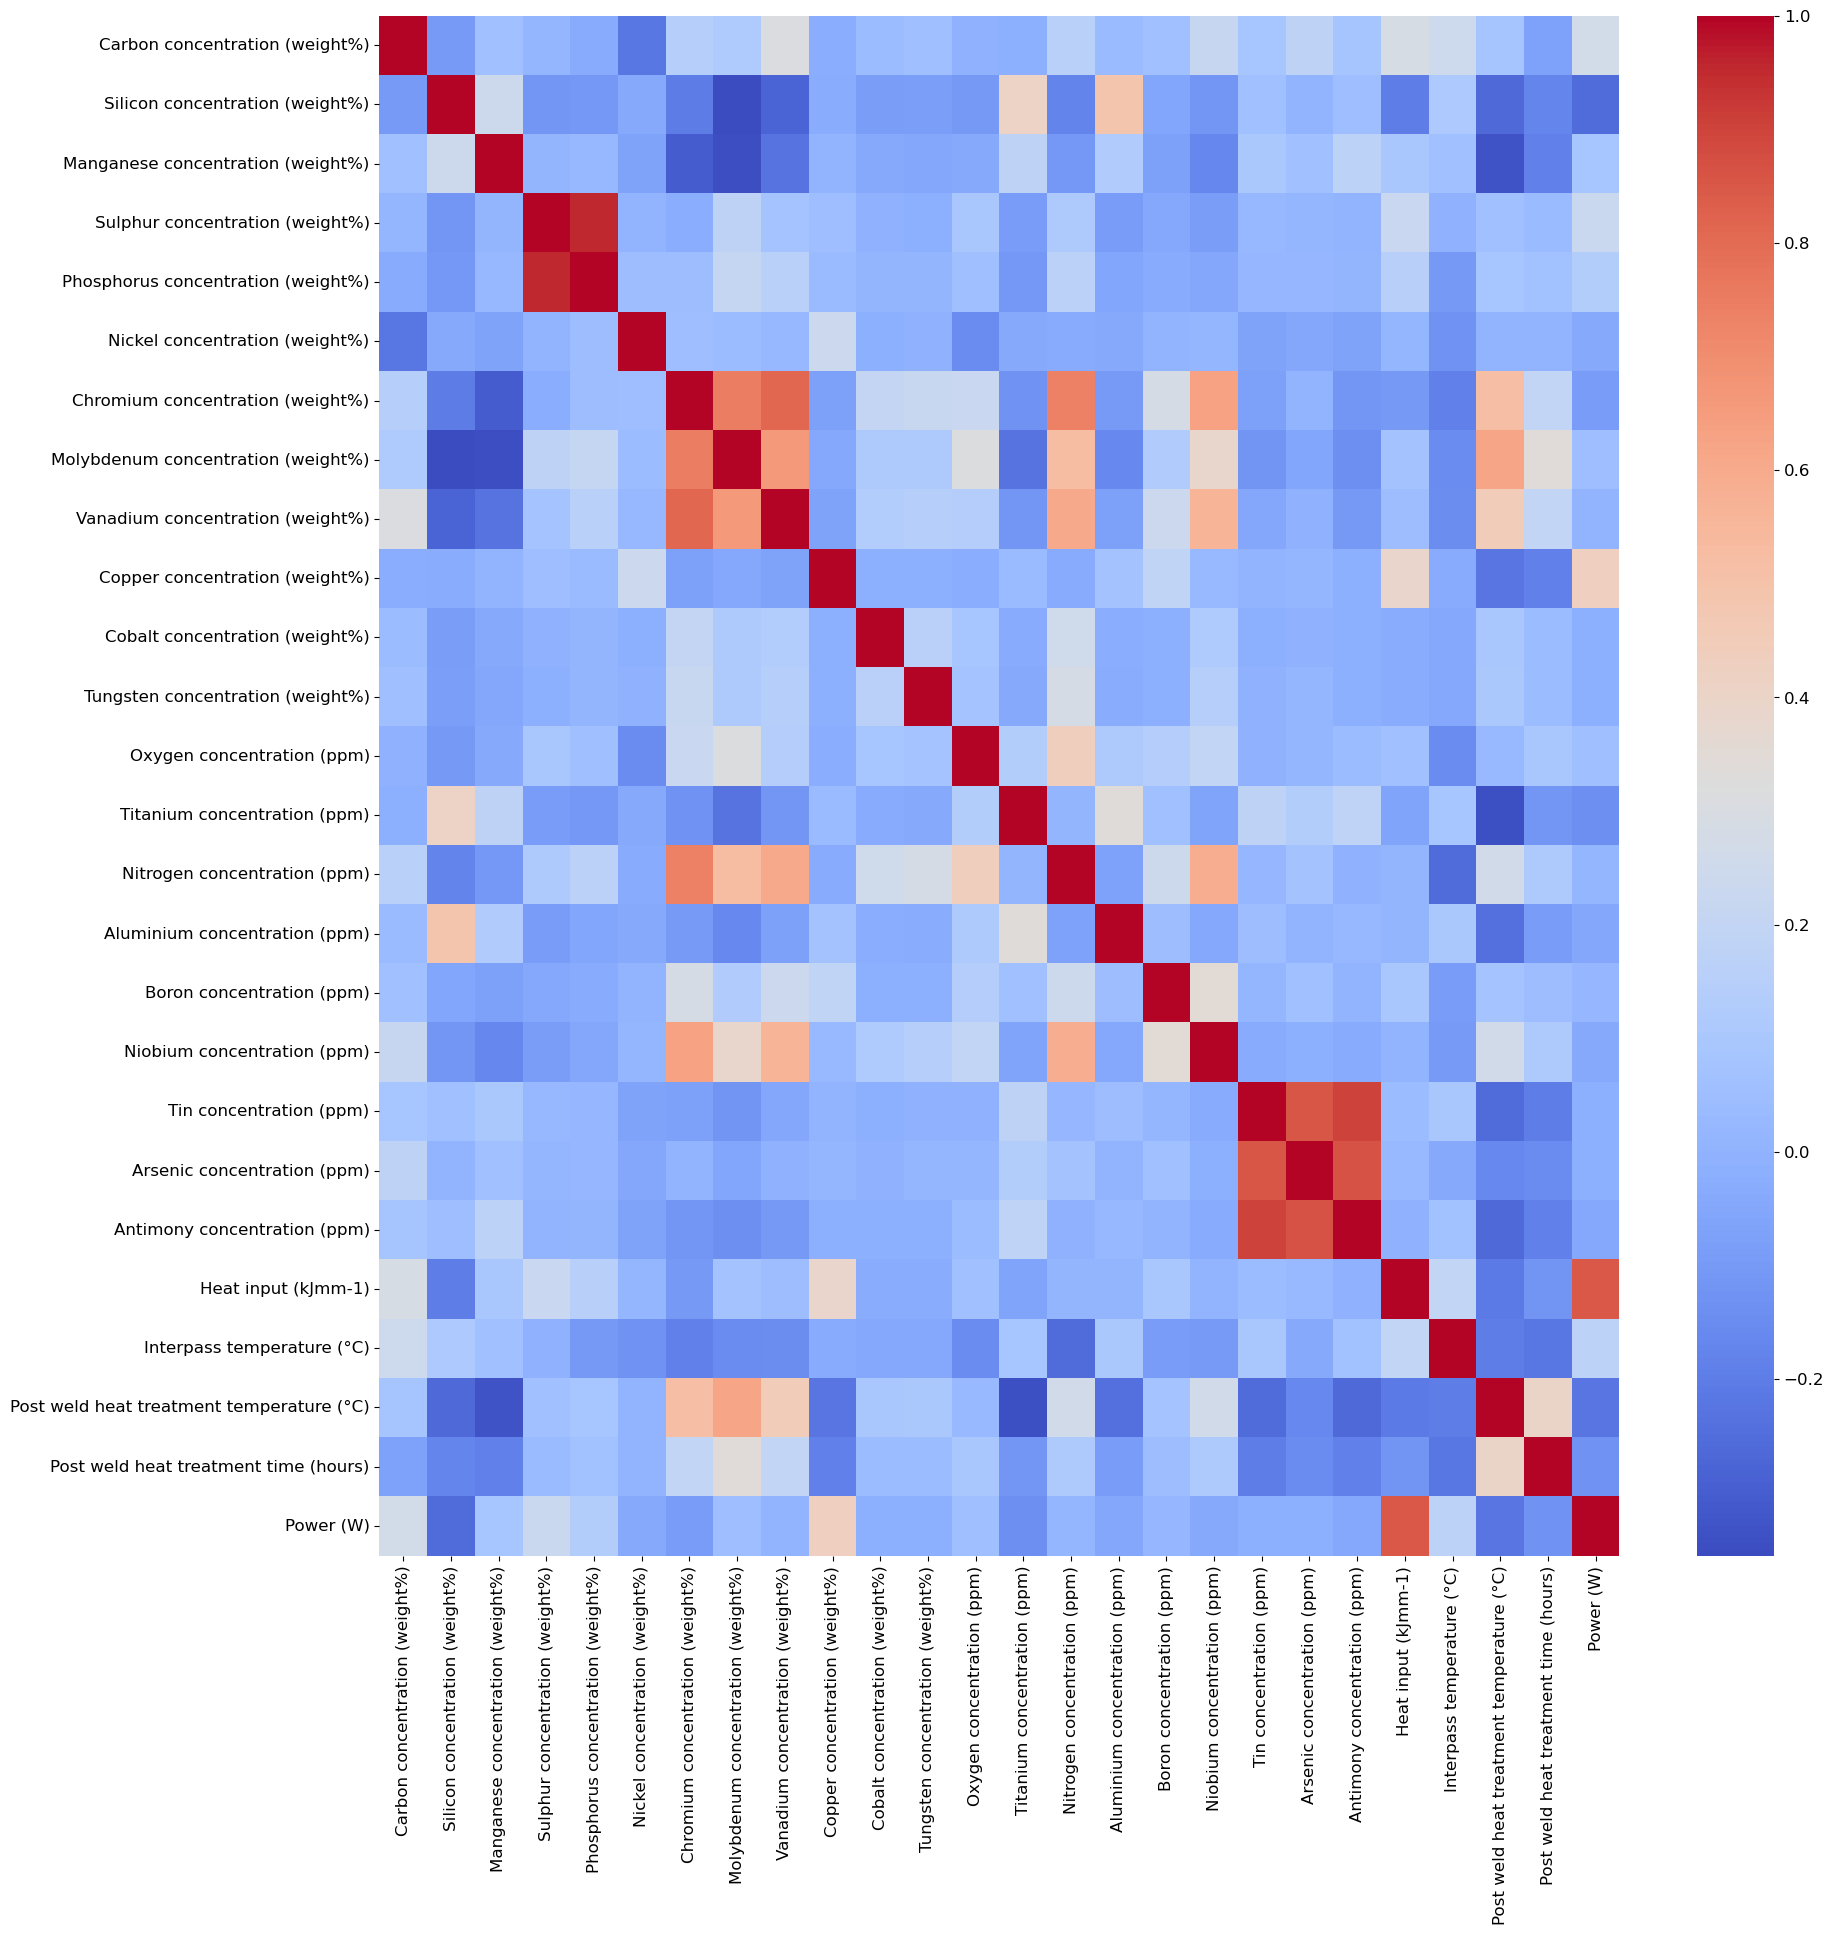

In [433]:
# Plotting the correlation heatmap
f, ax = plt.subplots(figsize=(20, 20))
ax = sns.heatmap(X_correlation.corr(), 
                 xticklabels=X_correlation.columns,
                 yticklabels=X_correlation.columns,
                 cmap='coolwarm')

plt.show()

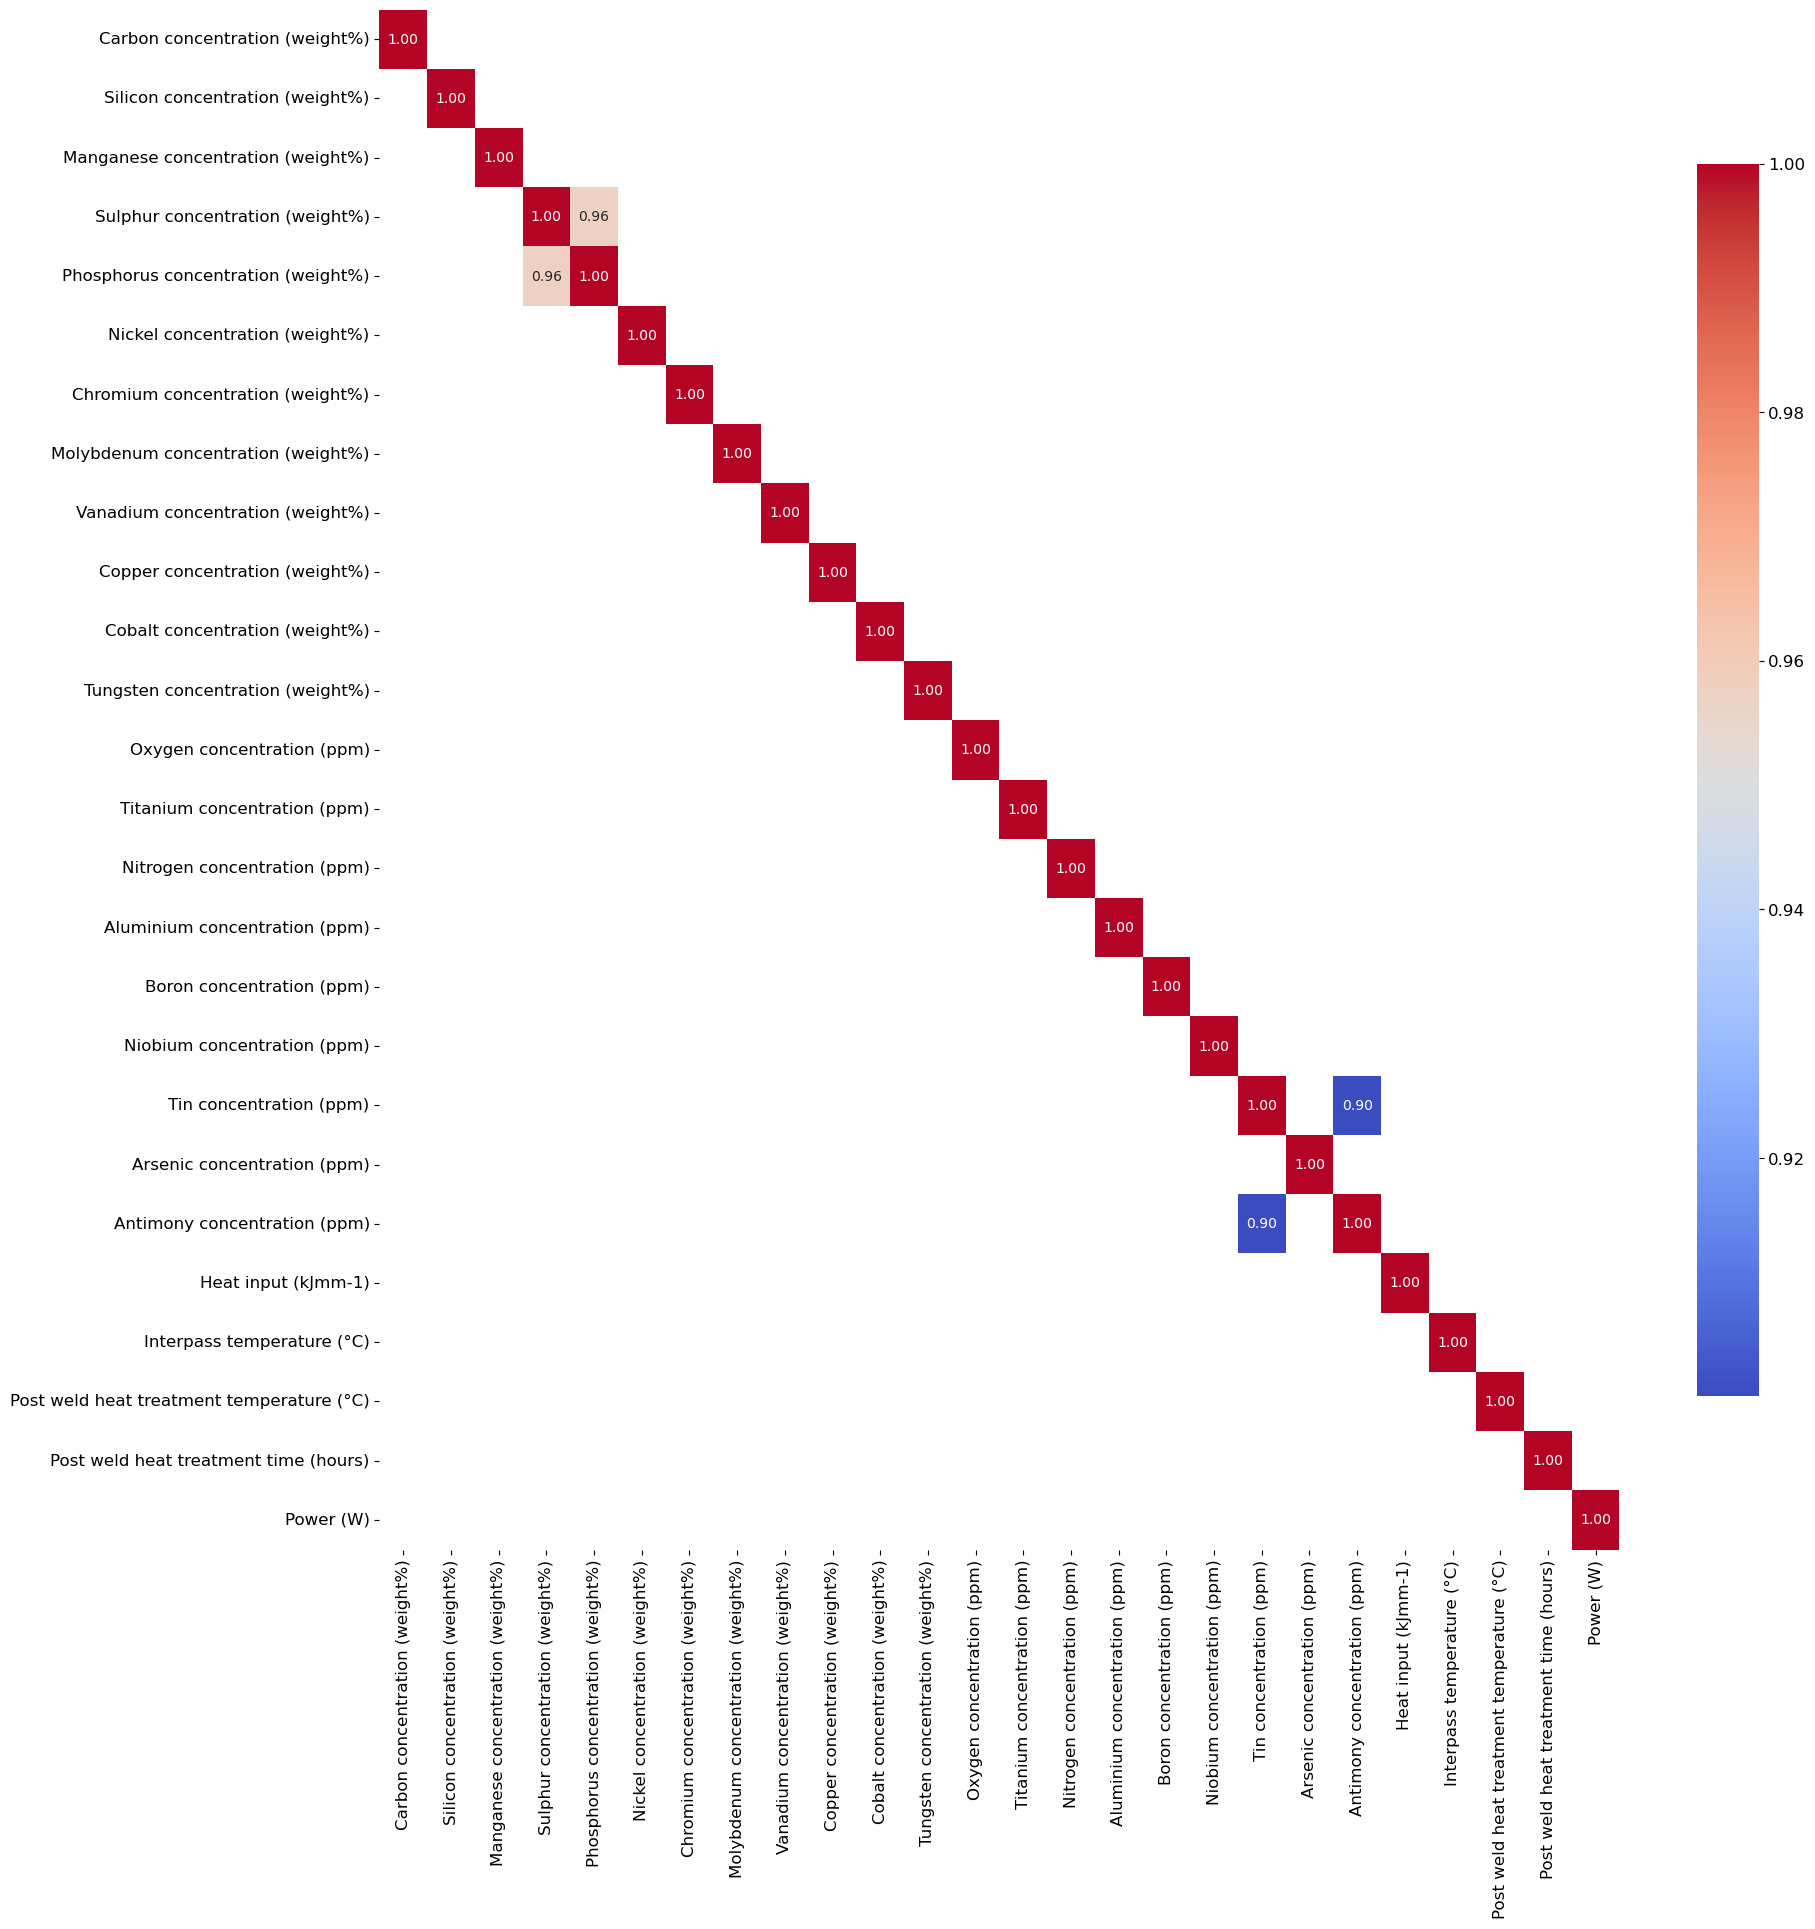

In [434]:
# Create the correlation matrix
corr_matrix = X_correlation.corr()

# Apply a mask to only show values with an absolute correlation higher than 0.9
mask = np.abs(corr_matrix) < 0.9

f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corr_matrix, 
            mask=mask,  # Mask values below the threshold
            xticklabels=X_correlation.columns,
            yticklabels=X_correlation.columns,
            cmap='coolwarm',  # Optional: choose a color palette
            annot=True,       # Show the correlation values in the cells
            fmt=".2f",        # Format the annotation to 2 decimal places
            cbar_kws={"shrink": .8})  # Optional: adjust colorbar size

plt.show()

We identified two pairs of highly correlated features:

1. **Sulphur concentration (weight%)** and **Phosphorus concentration (weight%)**
2. **Antimony concentration (ppm)** and **Tin concentration (ppm)**

For the first set, we retained the feature that demonstrated a stronger correlation with the target variable. For the second set, since both features contained a large percentage of zero values, we opted to keep the one with fewer zero entries to preserve more informative data.

In [435]:
# Calculate correlation with the target
correlation_with_target = X_correlation[['Sulphur concentration (weight%)', 
                                         'Phosphorus concentration (weight%)']].corrwith(welddb_ssl_cleaned[target_column])
print(correlation_with_target)

Sulphur concentration (weight%)      -0.411487
Phosphorus concentration (weight%)   -0.370026
dtype: float64


In [436]:
# Check the proportion of zero values in the features
zero_values = (X_correlation == 0).sum() / X_correlation.shape[0]
print(zero_values[zero_values > 0])

Nickel concentration (weight%)               0.721500
Chromium concentration (weight%)             0.648814
Molybdenum concentration (weight%)           0.635042
Vanadium concentration (weight%)             0.498087
Copper concentration (weight%)               0.772762
Cobalt concentration (weight%)               0.945677
Tungsten concentration (weight%)             0.986228
Oxygen concentration (ppm)                   0.237950
Titanium concentration (ppm)                 0.451415
Nitrogen concentration (ppm)                 0.260138
Aluminium concentration (ppm)                0.526396
Boron concentration (ppm)                    0.733741
Niobium concentration (ppm)                  0.634277
Tin concentration (ppm)                      0.830145
Arsenic concentration (ppm)                  0.839327
Antimony concentration (ppm)                 0.848508
Post weld heat treatment temperature (°C)    0.439174
Post weld heat treatment time (hours)        0.439174
dtype: float64


In [437]:
welddb_ssl_selected = welddb_ssl_selected.drop(['Antimony concentration (ppm)', 'Phosphorus concentration (weight%)'], axis=1)

In [438]:
welddb_ssl_selected.shape

(1652, 28)

## Get Dummy Variables For the Categorical Features

In [439]:
def dummy_variables(df, target_column, categorical_columns):
    """
    Prepares the feature matrix X and target vector y from a dataframe by creating dummy variables.
    
    Parameters:
    df (pd.DataFrame): The input dataframe.
    target_column (str): The name of the target column.
    categorical_columns (list): List of categorical columns to convert to dummy variables.
    
    Returns:
    X (pd.DataFrame): The feature matrix with dummy variables.
    y (pd.Series): The target variable.
    """
    dummies = pd.get_dummies(df[categorical_columns], drop_first=True)

    y = df[target_column]

    X_ = df.drop(categorical_columns + [target_column], axis=1).astype('float64')
    X = pd.concat([X_, dummies], axis=1)
    
    return X, y

In [440]:
X, y = dummy_variables(welddb_ssl_selected, target_column, categorical_columns)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 34 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Carbon concentration (weight%)             1652 non-null   float64
 1   Silicon concentration (weight%)            1652 non-null   float64
 2   Manganese concentration (weight%)          1652 non-null   float64
 3   Sulphur concentration (weight%)            1652 non-null   float64
 4   Nickel concentration (weight%)             1652 non-null   float64
 5   Chromium concentration (weight%)           1652 non-null   float64
 6   Molybdenum concentration (weight%)         1652 non-null   float64
 7   Vanadium concentration (weight%)           1652 non-null   float64
 8   Copper concentration (weight%)             1652 non-null   float64
 9   Cobalt concentration (weight%)             1652 non-null   float64
 10  Tungsten concentration (

In [441]:
original_columns = X.columns.tolist() # for the use of converting the NumPy array into a pandas DataFrame later

## Impute Missing Values Using KNN

In this project, it is difficult to determine the underlying patterns or mechanisms behind the missing data, which typically fall under MCAR, MAR or MNAR. K-Nearest Neighbors (KNN) is well-suited for this scenario, as it does not rely on assumptions about the nature of the missing data. KNN imputes missing values based on the similarity between neighboring data points.

In [442]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

In [443]:
# scale the data using MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Apply KNN Imputer on the scaled data
knn_imputer = KNNImputer(n_neighbors=5)
X_imputed = knn_imputer.fit_transform(X_scaled)

X = X_imputed

In [444]:
# Check NaN values
nan_exists = np.isnan(X).any()

if nan_exists:
    print("There are NaN values in the array.")
else:
    print("No NaN values in the array.")

No NaN values in the array.


## Supervised Learning - Random Forest

In [445]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, root_mean_squared_error

In [446]:
# Select only the labeled data for supervised learning
welddb_rf = welddb_ssl_selected.dropna(subset=[target_column])

In [447]:
welddb_rf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 138 entries, 879 to 1414
Data columns (total 28 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Carbon concentration (weight%)             138 non-null    float64
 1   Silicon concentration (weight%)            138 non-null    float64
 2   Manganese concentration (weight%)          138 non-null    float64
 3   Sulphur concentration (weight%)            138 non-null    float64
 4   Nickel concentration (weight%)             138 non-null    float64
 5   Chromium concentration (weight%)           138 non-null    float64
 6   Molybdenum concentration (weight%)         138 non-null    float64
 7   Vanadium concentration (weight%)           138 non-null    float64
 8   Copper concentration (weight%)             138 non-null    float64
 9   Cobalt concentration (weight%)             138 non-null    float64
 10  Tungsten concentration (weig

In [448]:
X_rf, y_rf = dummy_variables(welddb_rf, target_column, categorical_columns)
X_rf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 138 entries, 879 to 1414
Data columns (total 26 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Carbon concentration (weight%)             138 non-null    float64
 1   Silicon concentration (weight%)            138 non-null    float64
 2   Manganese concentration (weight%)          138 non-null    float64
 3   Sulphur concentration (weight%)            138 non-null    float64
 4   Nickel concentration (weight%)             138 non-null    float64
 5   Chromium concentration (weight%)           138 non-null    float64
 6   Molybdenum concentration (weight%)         138 non-null    float64
 7   Vanadium concentration (weight%)           138 non-null    float64
 8   Copper concentration (weight%)             138 non-null    float64
 9   Cobalt concentration (weight%)             138 non-null    float64
 10  Tungsten concentration (weig

In [449]:
X_rf_scaled = scaler.fit_transform(X_rf)
X_rf_imputed = knn_imputer.fit_transform(X_rf_scaled)

X_rf = X_rf_imputed

We evaluate the model using Adjusted R², as there is a different number of features due to the creation of dummy variables in the semi-supervised learning setup compared to the supervised learning setup. The Adjusted R² is calculated using the following formula:

$$
R_{\text{adj}}^2 = 1 - \left( \frac{(1 - R^2)(n - 1)}{n - p - 1} \right)
$$

Where:
- *R*$_{\text{adj}}^2$ is the Adjusted R².
- *R²* is the regular R² (coefficient of determination).
- *n* is the number of observations (data points).
- *p* is the number of predictors (features) in the model.

In [450]:
def adjusted_r2(r2, n, p):
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

In [453]:
# To have better comparable results, we perform a K-Fold validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
rf = RandomForestRegressor(random_state=42)

n_rf = X_rf.shape[0]
p_rf = X_rf.shape[1]

scores_r2 = np.empty(n_splits)
scores_adj_r2 = np.empty(n_splits)
scores_rmse = np.empty(n_splits)

for fold, (train_index, test_index) in enumerate(kf.split(X_rf)):
    X_train = X_rf[train_index, :]
    y_train = y_rf.iloc[train_index]
    X_test = X_rf[test_index, :]
    y_test = y_rf.iloc[test_index]
    
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    scores_r2[fold] = r2_score(y_test, y_pred)
    scores_adj_r2[fold] = adjusted_r2(r2_score(y_test, y_pred), n_rf, p_rf)
    scores_rmse[fold] = root_mean_squared_error(y_test, y_pred)

print(f"Average R2: {scores_r2.mean()}")
print(f"Average Adjusted R2: {scores_adj_r2.mean()}")
print(f"Average RMSE: {scores_rmse.mean()}")

Average R2: 0.8173657891019749
Average Adjusted R2: 0.7745866045673022
Average RMSE: 24.57349026725246


In [454]:
from sklearn.model_selection import train_test_split, GridSearchCV

Use cross validation with GridSearchCV to search for good combination of hyperparameters:

In [455]:
# Split the data into training and testing sets (80% training, 20% testing by default)
X_train, X_test, y_train, y_test = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 5],  # Minimum number of samples required to be at a leaf node
}

rf = RandomForestRegressor(random_state=42)

# Set up the GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

# Perform the grid search with cross-validation on the training set
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [10, 20, 30],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]})

In [456]:
# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the best model on the training data
y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
adj_r2 = adjusted_r2(r2, n_rf, p_rf)
rmse = root_mean_squared_error(y_test, y_pred)
print(f"Best model R2: {r2}")
print(f"Best model adjusted R2: {adj_r2}")
print(f"Best model RMSE: {rmse}")

Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best model R2: 0.8209093903672393
Best model adjusted R2: 0.7789602385613674
Best model RMSE: 31.721106354139433


Calculate the mean, standard deviation, and baseline RMSE of the target variable for model evaluation:

In [457]:
mean_y_rf = np.mean(y_rf)
std_y_rf = np.std(y_rf)
print(f"Mean of target (y_rf): {mean_y_rf}")
print(f"Standard deviation of target (y_rf): {std_y_rf}")

# Calculate the baseline RMSE
y_baseline = np.full_like(y_rf, mean_y_rf)
baseline_rmse = root_mean_squared_error(y_rf, y_baseline)
print(f"Baseline RMSE: {baseline_rmse}")


Mean of target (y_rf): 224.26108695652172
Standard deviation of target (y_rf): 63.06363519177383
Baseline RMSE: 63.06363519177383


**RMSE as a percentage of the mean**: This metric is calculated to assess the relative size of the RMSE compared to the mean of the target variable.

  The formula is:

  $$ \textit{RMSE\ as\ a\ percentage\ of\ mean} = \left( \frac{\textit{RMSE}}{\textit{mean\ of\ the\ target}} \right) \times 100 $$

**Improvement over baseline RMSE**: This calculation measures the percentage improvement of the current model's RMSE compared to a baseline model. The baseline RMSE could represent a simple model, such as one that always predicts the mean value of the target variable.

  The formula is:

  $$ \textit{Improvement\ over\ baseline\ RMSE} = \left( \frac{\textit{Baseline\ RMSE} - \textit{Current\ RMSE}}{\textit{Baseline\ RMSE}} \right) \times 100 $$

In [458]:
rmse_percentage_mean = (rmse / mean_y_rf) * 100
improvement_rmse = ((baseline_rmse - rmse) / baseline_rmse) * 100
print(f"RMSE as a percentage of mean: {rmse_percentage_mean}%")
print(f"Improvement over baseline RMSE: {improvement_rmse}%")

RMSE as a percentage of mean: 14.144721576369292%
Improvement over baseline RMSE: 49.69984483501958%


In [459]:
# We build a dataframe for storing and comparing results
df_results = pd.DataFrame(columns=['Method', 'Best Hyperparameters', 'Best R2', 'Best Adjusted R2', 'Best RMSE', 
                                   'RMSE as % of Mean', 'Improvement over Baseline RMSE'])

In [460]:
new_row = pd.DataFrame({
    'Method': ['Supervised - RandomForest'],
    'Best Hyperparameters': [str(best_params)],
    'Best R2': [round(r2, 3)],
    'Best Adjusted R2': [round(adj_r2, 3)],
    'Best RMSE': [round(rmse, 3)],
    'RMSE as % of Mean': ['{}%'.format(round(rmse_percentage_mean, 2))],
    'Improvement over Baseline RMSE': ['{}%'.format(round(improvement_rmse, 2))]
})

df_results = pd.concat([df_results, new_row], ignore_index=True)

C:\Users\12264\AppData\Local\Temp\ipykernel_19876\4229797583.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([df_results, new_row], ignore_index=True)


In [461]:
df_results

,Method,Best Hyperparameters,Best R2,Best Adjusted R2,Best RMSE,RMSE as % of Mean,Improvement over Baseline RMSE
0,Supervised - RandomForest,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}",0.821,0.779,31.721,14.14%,49.7%


## Self-Training - Random Forest

In [462]:
X_rf.shape

(138, 26)

In [463]:
X.shape

(1652, 34)

In [464]:
y.shape

(1652,)

In [465]:
X = pd.DataFrame(X, columns=original_columns)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 34 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Carbon concentration (weight%)             1652 non-null   float64
 1   Silicon concentration (weight%)            1652 non-null   float64
 2   Manganese concentration (weight%)          1652 non-null   float64
 3   Sulphur concentration (weight%)            1652 non-null   float64
 4   Nickel concentration (weight%)             1652 non-null   float64
 5   Chromium concentration (weight%)           1652 non-null   float64
 6   Molybdenum concentration (weight%)         1652 non-null   float64
 7   Vanadium concentration (weight%)           1652 non-null   float64
 8   Copper concentration (weight%)             1652 non-null   float64
 9   Cobalt concentration (weight%)             1652 non-null   float64
 10  Tungsten concentration (

In [466]:
from sklearn.base import clone

The `SelfTrainingRegressor` class implements a semi-supervised learning algorithm. It works as follows:

1. **Initialization**: Accepts a base estimator (like RandomForest), RMSE threshold (to select confident predictions), and max iterations.
   
2. **Model Fitting**:
   - The labeled and unlabeled data are split.
   - The model is trained on labeled data, then predicts on the unlabeled data.
   - Confident predictions are added to the labeled set, and the process repeats.
   - Final training is done on the expanded labeled set.

3. **Prediction**: Uses the trained model to predict target values for new data.

4. **Logging**: The `fit_and_log_labeled_data` method records the number of labeled samples added in each iteration, providing insight into how the model progressively incorporates unlabeled data during training.

For confident predictions, we set a threshold based on the distance between the predicted values for the unlabeled data and the mean of the labeled data. Specifically, we calculate the absolute difference between the predicted values and the mean and compare it to the standard deviation of the labeled data.

In [469]:
# Custom Self-Training Regressor
class SelfTrainingRegressor:
    def __init__(self, base_estimator, rmse_threshold, max_iter=10):
        self.base_estimator = base_estimator
        self.rmse_threshold = rmse_threshold
        self.max_iter = max_iter
    
    def get_params(self, deep=True):
        """Get hyperparameters for grid search compatibility."""
        return {
            'base_estimator': self.base_estimator,
            'rmse_threshold': self.rmse_threshold,
            'max_iter': self.max_iter
        }

    def set_params(self, **params):
        """Set hyperparameters for grid search compatibility."""
        for param, value in params.items():
            setattr(self, param, value)
        return self

    def fit(self, X, y):
        labeled_mask = ~y.isna()  # Identify labeled samples (where y is not NaN)
        X_labeled = X[labeled_mask]
        y_labeled = y[labeled_mask]
        X_unlabeled = X[~labeled_mask]  # Unlabeled data (where y is NaN)

        # Self-training process
        X_train = X_labeled.copy()
        y_train = y_labeled.copy()
        expected_value = np.mean(y_labeled)  # Expected value based on the labeled data

        for iteration in range(self.max_iter):
            model = clone(self.base_estimator)
            model.fit(X_train, y_train)

            # Predict on the unlabeled data
            if X_unlabeled.shape[0] == 0:
                break  # If no unlabeled data, break early
            y_pred_unlabeled = model.predict(X_unlabeled)

            # Get the most confident predictions
            confident_indices = np.abs(y_pred_unlabeled - expected_value) < self.rmse_threshold
            if confident_indices.sum() == 0:
                break  # Stop if no confident predictions

            # Add the confident predictions to the training set
            X_train = pd.concat([X_train, X_unlabeled[confident_indices]], axis=0)
            y_train = pd.concat([y_train, pd.Series(y_pred_unlabeled[confident_indices], index=X_unlabeled[confident_indices].index)], axis=0)
            
            X_unlabeled = X_unlabeled[~confident_indices] # Remove the confident samples from the unlabeled set

        # Final fit on the extended training set
        self.model_ = model
        self.model_.fit(X_train, y_train)

    def predict(self, X):
        return self.model_.predict(X)
    
    # New method to log the number of labeled data at each iteration
    def fit_and_log_labeled_data(self, X, y):
        labeled_mask = ~y.isna()
        X_labeled = X[labeled_mask]
        y_labeled = y[labeled_mask]
        X_unlabeled = X[~labeled_mask]

        X_train = X_labeled.copy()
        y_train = y_labeled.copy()
        expected_value = np.mean(y_labeled)
        
        labeled_data_count = [len(X_train)]
        
        for iteration in range(self.max_iter):
            model = clone(self.base_estimator)
            model.fit(X_train, y_train)

            if X_unlabeled.shape[0] == 0:
                break
            y_pred_unlabeled = model.predict(X_unlabeled)

            confident_indices = np.abs(y_pred_unlabeled - expected_value) < self.rmse_threshold
            if confident_indices.sum() == 0:
                break

            X_train = pd.concat([X_train, X_unlabeled[confident_indices]], axis=0)
            y_train = pd.concat([y_train, pd.Series(y_pred_unlabeled[confident_indices], index=X_unlabeled[confident_indices].index)], axis=0)

            labeled_data_count.append(len(X_train)) # Log the number of labeled samples
            X_unlabeled = X_unlabeled[~confident_indices] # Remove the confident samples from the unlabeled set

        self.model_ = model
        self.model_.fit(X_train, y_train)

        return labeled_data_count # Return the labeled data count for plotting


In [472]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

n_ssl = X.shape[0]
p_ssl = X.shape[1]

labeled_mask = ~y.isna()  # Mask to select labeled data (where y is not NaN)
X_labeled = X[labeled_mask]
y_labeled = y[labeled_mask]
X_unlabeled = X[~labeled_mask]  # Unlabeled data (where y is NaN)

rf = RandomForestRegressor(random_state=42)
self_training_regressor = SelfTrainingRegressor(base_estimator=rf, rmse_threshold=std_y_rf)

# Arrays to store results
scores_r2 = np.empty(n_splits)
scores_adj_r2 = np.empty(n_splits)
scores_rmse = np.empty(n_splits)

for fold, (train_index, test_index) in enumerate(kf.split(X_labeled)):
    X_train_labeled = X_labeled.iloc[train_index].reset_index(drop=True)
    y_train_labeled = y_labeled.iloc[train_index].reset_index(drop=True)
    X_test_labeled = X_labeled.iloc[test_index].reset_index(drop=True)
    y_test_labeled = y_labeled.iloc[test_index].reset_index(drop=True)

    # Combine the labeled training data with the unlabeled data for SSL
    X_train_full = pd.concat([X_train_labeled, X_unlabeled], axis=0).reset_index(drop=True)
    y_train_full = pd.concat([y_train_labeled, pd.Series([np.nan] * len(X_unlabeled))], axis=0).reset_index(drop=True)

    # Fit the model with both labeled and unlabeled data
    self_training_regressor.fit(X_train_full, y_train_full)

    y_pred = self_training_regressor.predict(X_test_labeled)

    scores_r2[fold] = r2_score(y_test_labeled, y_pred)
    scores_adj_r2[fold] = adjusted_r2(r2_score(y_test_labeled, y_pred), n_ssl, p_ssl)
    scores_rmse[fold] = root_mean_squared_error(y_test_labeled, y_pred)

print(f"Average R2: {scores_r2.mean()}")
print(f"Average Adjusted R2: {scores_adj_r2.mean()}")
print(f"Average RMSE: {scores_rmse.mean()}")

Average R2: 0.8751450482096115
Average Adjusted R2: 0.872519774022306
Average RMSE: 19.7546705033182


Plot the variation in the number of labeled data points:

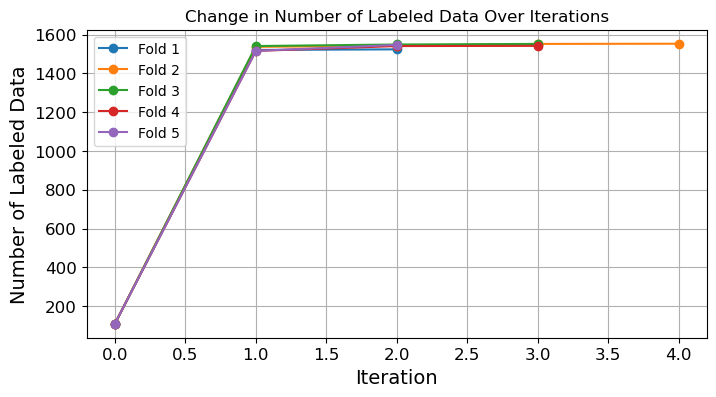

Average R2: 0.8751450482096115
Average RMSE: 19.7546705033182


In [473]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

labeled_mask = ~y.isna()
X_labeled = X[labeled_mask]
y_labeled = y[labeled_mask]
X_unlabeled = X[~labeled_mask]

rf = RandomForestRegressor(random_state=42)
self_training_regressor = SelfTrainingRegressor(base_estimator=rf, rmse_threshold=std_y_rf)

scores_r2 = np.empty(n_splits)
scores_rmse = np.empty(n_splits)

labeled_data_log = [] # Arrays to store the number of labeled data at each iteration for plotting

for fold, (train_index, test_index) in enumerate(kf.split(X_labeled)):
    X_train_labeled = X_labeled.iloc[train_index].reset_index(drop=True)
    y_train_labeled = y_labeled.iloc[train_index].reset_index(drop=True)
    X_test_labeled = X_labeled.iloc[test_index].reset_index(drop=True)
    y_test_labeled = y_labeled.iloc[test_index].reset_index(drop=True)

    X_train_full = pd.concat([X_train_labeled, X_unlabeled], axis=0).reset_index(drop=True)
    y_train_full = pd.concat([y_train_labeled, pd.Series([np.nan] * len(X_unlabeled))], axis=0).reset_index(drop=True)

    # Fit the model with both labeled and unlabeled data and log the number of labeled data
    labeled_data_log_fold = self_training_regressor.fit_and_log_labeled_data(X_train_full, y_train_full)
    labeled_data_log.append(labeled_data_log_fold)

    y_pred = self_training_regressor.predict(X_test_labeled)

    scores_r2[fold] = r2_score(y_test_labeled, y_pred)
    scores_rmse[fold] = root_mean_squared_error(y_test_labeled, y_pred)

# Plotting the change in the number of labeled data over iterations for each fold
plt.figure(figsize=(8, 4))
for i, log in enumerate(labeled_data_log):
    plt.plot(range(len(log)), log, marker='o', label=f'Fold {i+1}')

plt.title('Change in Number of Labeled Data Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Number of Labeled Data')
plt.legend()
plt.grid(True)
plt.show()

print(f"Average R2: {scores_r2.mean()}")
# print(f"Average Adjusted R2: {scores_adj_r2.mean()}")
print(f"Average RMSE: {scores_rmse.mean()}")

The plot shows that the number of labeled data increases significantly in the first iteration for all five folds, after which it remains nearly constant. This suggests that most confident predictions are made early in the self-training process, and further iterations do not add many new labeled data points. The consistency across folds indicates that this behavior is robust across different data splits.

The `CustomLabeledUnlabeledKFold` class handles cross-validation for semi-supervised learning, where both labeled and unlabeled data are present. It performs K-Fold splitting only on the labeled data, ensuring that the validation set contains labeled samples, while the training set includes both labeled and unlabeled data. This approach allows the model to use unlabeled data during training but evaluates its performance only on the labeled data.

In [475]:
class CustomLabeledUnlabeledKFold:
    def __init__(self, n_splits=5, shuffle=True, random_state=None):
        self.kf = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

    def get_n_splits(self, X, y, groups=None):
        return self.kf.get_n_splits(X, y, groups)

    def split(self, X, y, groups=None):
        # Ensure y is a pandas Series to use .isna()
        if not isinstance(y, pd.Series):
            y = pd.Series(y)

        labeled_indices = y[~y.isna()].index  # Labeled data indices
        unlabeled_indices = y[y.isna()].index  # Unlabeled data indices

        # Perform K-Fold splitting on the labeled data only
        for labeled_train_idx, labeled_val_idx in self.kf.split(labeled_indices):
            # Map the labeled indices back to the original dataset
            train_indices = labeled_indices[labeled_train_idx].to_list() + unlabeled_indices.to_list()
            val_indices = labeled_indices[labeled_val_idx].to_list()

            yield train_indices, val_indices

The GridSearchCV process below takes 15-20 minutes to complete.

In [476]:
X_train_labeled, X_test_labeled, y_train_labeled, y_test_labeled = train_test_split(
    X_labeled, y_labeled, test_size=0.2, random_state=42)

X_train_full = pd.concat([pd.DataFrame(X_train_labeled), pd.DataFrame(X_unlabeled)], axis=0).reset_index(drop=True)
y_train_full = pd.concat([pd.Series(y_train_labeled), pd.Series([np.nan] * len(X_unlabeled))], axis=0).reset_index(drop=True)

param_grid = {
    'base_estimator__n_estimators': [50, 100, 200],
    'base_estimator__max_depth': [10, 20, 30],
    'base_estimator__min_samples_split': [2, 5, 10],
    'base_estimator__min_samples_leaf': [1, 2, 5],
}

rf = RandomForestRegressor(random_state=42)
self_training_regressor = SelfTrainingRegressor(base_estimator=rf, rmse_threshold=std_y_rf, max_iter=10)
custom_cv = CustomLabeledUnlabeledKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=self_training_regressor, 
                            param_grid=param_grid, 
                            cv=custom_cv, 
                            scoring='r2')

grid_search.fit(X_train_full, y_train_full)

GridSearchCV(cv=<__main__.CustomLabeledUnlabeledKFold object at 0x0000019AF0FF5970>,
             estimator=<__main__.SelfTrainingRegressor object at 0x0000019A8CF10CE0>,
             param_grid={'base_estimator__max_depth': [10, 20, 30],
                         'base_estimator__min_samples_leaf': [1, 2, 5],
                         'base_estimator__min_samples_split': [2, 5, 10],
                         'base_estimator__n_estimators': [50, 100, 200]},
             scoring='r2')

In [477]:
best_params_ssl = grid_search.best_params_
print(f"Best parameters: {best_params_ssl}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_labeled)

r2_ssl = r2_score(y_test_labeled, y_pred)
adj_r2_ssl = adjusted_r2(r2_ssl, n_ssl, p_ssl)
rmse_ssl = root_mean_squared_error(y_test_labeled, y_pred)
print(f"Best model R2: {r2_ssl}")
print(f"Best model adjusted R2: {adj_r2_ssl}")
print(f"Best model RMSE: {rmse_ssl}")

Best parameters: {'base_estimator__max_depth': 10, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'base_estimator__n_estimators': 50}
Best model R2: 0.9192283038725316
Best model adjusted R2: 0.917529950336147
Best model RMSE: 21.30303691779887


In [478]:
rmse_percentage_mean_ssl = (rmse_ssl / mean_y_rf) * 100
improvement_rmse_ssl = ((baseline_rmse - rmse_ssl) / baseline_rmse) * 100

In [479]:
new_row = pd.DataFrame({
    'Method': ['Self-Training - RandomForest'],
    'Best Hyperparameters': [str(best_params_ssl)],
    'Best R2': [round(r2_ssl, 3)],
    'Best Adjusted R2': [round(adj_r2_ssl, 3)],
    'Best RMSE': [round(rmse_ssl, 3)],
    'RMSE as % of Mean': ['{}%'.format(round(rmse_percentage_mean_ssl, 2))],
    'Improvement over Baseline RMSE': ['{}%'.format(round(improvement_rmse_ssl, 2))]
})

df_results = pd.concat([df_results, new_row], ignore_index=True)

In [480]:
pd.set_option('display.max_colwidth', None)
df_results

,Method,Best Hyperparameters,Best R2,Best Adjusted R2,Best RMSE,RMSE as % of Mean,Improvement over Baseline RMSE
0,Supervised - RandomForest,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}",0.821,0.779,31.721,14.14%,49.7%
1,Self-Training - RandomForest,"{'base_estimator__max_depth': 10, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'base_estimator__n_estimators': 50}",0.919,0.918,21.303,9.5%,66.22%


The results indicate that the self-training method outperforms the supervised approach. This demonstrates the value of incorporating unlabeled data, as self-training significantly enhanced the model's predictive accuracy.


# Predict All Targets Using Supervised and Self-Training Learning

Previously, we removed the feature **Phosphorus concentration (weight%)** due to its weaker correlation with **Hardness (kgmm-2)**. However, as we are now proceeding to encapsulate the process into a function for iterative target prediction, we will retain this feature. Consequently, the model for predicting **Hardness (kgmm-2)** in the subsequent steps may slightly differ from the results obtained earlier.

In [481]:
welddb_ssl= welddb_ssl.drop(['Antimony concentration (ppm)'], axis=1)

In [496]:
welddb_ssl.shape

(1652, 35)

## Base Estimator - Random Forest

In [483]:
def prepare_dataset_for_rf(welddb_ssl_selected, target_column, categorical_columns):
    """
    Prepares the dataset for both supervised and semi-supervised learning.
    
    Parameters:
    - welddb_ssl_selected: The input dataframe containing both labeled and unlabeled data.
    - target_column: The name of the target variable column.
    - categorical_columns: List of categorical columns that need to be converted to dummy variables.
    
    Returns:
    - X_imputed: Scaled and imputed features for both labeled and unlabeled data (used in SSL).
    - y: The target variable, including NaNs for unlabeled data.
    - X_sl_imputed: Scaled and imputed features for only labeled data (used in SL).
    - y_sl: The target variable for only labeled data.
    - original_columns: List of original feature names after dummy encoding.
    """
    scaler = MinMaxScaler()
    knn_imputer = KNNImputer(n_neighbors=5)

    # Prepare for SL
    welddb_sl = welddb_ssl_selected.dropna(subset=[target_column])
    X_sl, y_sl = dummy_variables(welddb_sl, target_column, categorical_columns)
    X_sl_scaled = scaler.fit_transform(X_sl)
    X_sl_imputed = knn_imputer.fit_transform(X_sl_scaled)
    
    # Prepare for SSL
    X, y = dummy_variables(welddb_ssl_selected, target_column, categorical_columns)
    original_columns = X.columns.tolist()
    X_scaled = scaler.fit_transform(X)
    X_imputed = knn_imputer.fit_transform(X_scaled)
    
    return X_imputed, y, X_sl_imputed, y_sl, original_columns


In [484]:
def train_supervised_rf(X_sl, y_sl, target_column):
    """
    Trains a RandomForest model on the provided labeled data using supervised learning.
    It also evaluates the model's performance based on R2, adjusted R2, and RMSE.

    Parameters:
    - X_sl: Scaled and imputed feature matrix for labeled data.
    - y_sl: Target variable for labeled data.
    - target_column: Name of the target variable for logging.

    Returns:
    - new_row: DataFrame containing the best model's results.
    - std_y: Standard deviation of the target variable (used later for self-training).
    """
    X_train, X_test, y_train, y_test = train_test_split(X_sl, y_sl, test_size=0.2, random_state=42)

    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 5],
    }

    rf = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    n_sl = X_sl.shape[0]
    p_sl = X_sl.shape[1]

    # Evaluate the model
    y_pred = best_model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    adj_r2 = adjusted_r2(r2, n_sl, p_sl)
    rmse = root_mean_squared_error(y_test, y_pred)

    # Baseline RMSE
    mean_y = np.mean(y_sl)
    std_y = np.std(y_sl)
    y_baseline = np.full_like(y_sl, mean_y)
    baseline_rmse = root_mean_squared_error(y_sl, y_baseline)

    rmse_percentage_mean = (rmse / mean_y) * 100
    improvement_rmse = ((baseline_rmse - rmse) / baseline_rmse) * 100

    # Add results to df
    new_row = pd.DataFrame({
        'Method': [f'Supervised - RandomForest'],
        'Target': [f'{target_column}'],
        'Best Hyperparameters': [str(best_params)],
        'Best R2': [round(r2, 3)],
        'Best Adjusted R2': [round(adj_r2, 3)],
        'Best RMSE': [round(rmse, 3)],
        'RMSE as % of Mean': ['{}%'.format(round(rmse_percentage_mean, 2))],
        'Improvement over Baseline RMSE': ['{}%'.format(round(improvement_rmse, 2))]
    })

    return new_row, std_y

In [485]:
def train_self_training_rf(X_imputed, y, std_y, original_columns, target_column):
    """
    Trains a RandomForest model using self-training semi-supervised learning.
    The model first trains on labeled data, and then gradually incorporates the most confident predictions 
    from the unlabeled data.

    Parameters:
    - X_imputed: Scaled and imputed feature matrix for both labeled and unlabeled data.
    - y: Target variable, including NaNs for unlabeled data.
    - std_y: Standard deviation of the target variable (used for self-training threshold).
    - original_columns: List of original feature names after dummy encoding.
    - target_column: Name of the target variable for logging.

    Returns:
    - new_row: DataFrame containing the results of the self-training model.
    """
    X = pd.DataFrame(X_imputed, columns=original_columns)
    
    # Split for labeled/unlabeled
    labeled_mask = ~y.isna()
    X_labeled = X[labeled_mask]
    y_labeled = y[labeled_mask]
    X_unlabeled = X[~labeled_mask]

    X_train_labeled, X_test_labeled, y_train_labeled, y_test_labeled = train_test_split(
        X_labeled, y_labeled, test_size=0.2, random_state=42
    )

    # Combine for Self-Training
    X_train_full = pd.concat([pd.DataFrame(X_train_labeled), pd.DataFrame(X_unlabeled)], axis=0).reset_index(drop=True)
    y_train_full = pd.concat([pd.Series(y_train_labeled), pd.Series([np.nan] * len(X_unlabeled))], axis=0).reset_index(drop=True)

    param_grid = {
        'base_estimator__n_estimators': [50, 100, 200],
        'base_estimator__max_depth': [10, 20, 30],
        'base_estimator__min_samples_split': [2, 5, 10],
        'base_estimator__min_samples_leaf': [1, 2, 5],
    }

    rf = RandomForestRegressor(random_state=42)
    self_training_regressor = SelfTrainingRegressor(base_estimator=rf, rmse_threshold=std_y, max_iter=10)
    custom_cv = CustomLabeledUnlabeledKFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(estimator=self_training_regressor, 
                                param_grid=param_grid, 
                                cv=custom_cv, 
                                scoring='r2')
    grid_search.fit(X_train_full, y_train_full)

    best_params_ssl = grid_search.best_params_
    best_model = grid_search.best_estimator_

    n_ssl = X.shape[0]
    p_ssl = X.shape[1]

    # Evaluate the model
    y_pred = best_model.predict(X_test_labeled)
    r2_ssl = r2_score(y_test_labeled, y_pred)
    adj_r2_ssl = adjusted_r2(r2_ssl, n_ssl, p_ssl)
    rmse_ssl = root_mean_squared_error(y_test_labeled, y_pred)

    rmse_percentage_mean_ssl = (rmse_ssl / np.mean(y_labeled)) * 100
    improvement_rmse_ssl = ((root_mean_squared_error(y_labeled, np.full_like(y_labeled, np.mean(y_labeled))) - rmse_ssl) / root_mean_squared_error(y_labeled, np.full_like(y_labeled, np.mean(y_labeled)))) * 100

    new_row = pd.DataFrame({
        'Method': [f'Self-Training - RandomForest'],
        'Target': [f'{target_column}'],
        'Best Hyperparameters': [str(best_params_ssl)],
        'Best R2': [round(r2_ssl, 3)],
        'Best Adjusted R2': [round(adj_r2_ssl, 3)],
        'Best RMSE': [round(rmse_ssl, 3)],
        'RMSE as % of Mean': ['{}%'.format(round(rmse_percentage_mean_ssl, 2))],
        'Improvement over Baseline RMSE': ['{}%'.format(round(improvement_rmse_ssl, 2))]
    })

    return new_row


The function was designed to test whether removing certain features (e.g., those with low correlation to the target) could improve model performance. However, it did not yield better results, so it was ultimately not used. I’ve kept it here for potential use in future analyses.

In [486]:
def feature_filter(welddb_ssl_selected: pd.DataFrame, target_column: str) -> pd.DataFrame:
    """
    This function removes features that are either all zeros or have a correlation with the target
    lower than 0.1, and returns a cleaned dataframe.

    Parameters:
    welddb_ssl_selected (pd.DataFrame): Input dataframe.
    target_column (str): The name of the target column.
    categorical_columns (list): List of categorical columns that need to be dummy encoded.

    Returns:
    pd.DataFrame: Cleaned dataframe with selected features.
    """
    welddb_sl = welddb_ssl_selected.dropna()
    X_sl = welddb_sl.drop(columns=[target_column])
    y_sl = welddb_sl[target_column]

    # Remove features that are all zeros
    X_numeric = X_sl.select_dtypes(include=[float, int])
    zero_values = (X_numeric == 0).sum() / X_numeric.shape[0]

    zero_threshold = 1.0
    features_to_remove = zero_values[zero_values > zero_threshold].index.tolist()

    if features_to_remove:
        print(f"Features removed due to more than {zero_threshold * 100}% zeros: {features_to_remove}")

    X_numeric = X_numeric.drop(columns=features_to_remove)

    constant_features = X_numeric.columns[X_numeric.nunique() == 1].tolist()
    X_numeric = X_numeric.drop(columns=constant_features)
    data = pd.concat([X_numeric, y_sl], axis=1)
    correlation_matrix = data.corr()
    
    # Extract the correlation between each feature and the target column
    target_name = y_sl.name
    correlation_with_target = correlation_matrix[target_name]
    print("Correlation with target:\n", correlation_with_target)

    # corr_threshold = 0.1
    # features_to_remove += correlation_with_target[correlation_with_target.abs() < corr_threshold].index.tolist()

    # # Print the features removed due to low correlation with the target
    # features_removed_due_to_correlation = correlation_with_target[correlation_with_target.abs() < corr_threshold].index.tolist()
    # if features_removed_due_to_correlation:
    #     print(f"Features removed due to low correlation with the target: {features_removed_due_to_correlation}")

    # X_cleaned = X_filtered[features_to_keep]
    welddb_ssl_selected = welddb_ssl_selected.drop(columns=features_to_remove)
    print(welddb_ssl_selected.shape)

    return welddb_ssl_selected

In [487]:
def run_workflow_for_target(welddb_ssl, target_column, target_columns, categorical_columns, df_results_all):
    """
    Executes the full workflow for a specific target, training both a supervised RandomForest model and a 
    self-training semi-supervised RandomForest model, then returns the updated results.

    Parameters:
    - welddb_ssl: The input dataframe containing both labeled and unlabeled data.
    - target_column: The target variable to be predicted (e.g., hardness).
    - target_columns: A list of all target columns in the dataset.
    - categorical_columns: List of categorical columns to be encoded as dummy variables.
    - df_results_all: DataFrame to store the results of each target's model.

    Returns:
    - df_results_all: Updated DataFrame with results from both the supervised and semi-supervised models.
    """
    # Select the target and prepare the dataset
    welddb_ssl_selected = select_target(welddb_ssl, target_column, target_columns)
    welddb_ssl_filtered = welddb_ssl_selected
    # welddb_ssl_filtered = feature_filter(welddb_ssl_selected, target_column)
    X_imputed, y, X_sl_imputed, y_sl, original_columns = prepare_dataset_for_rf(welddb_ssl_filtered, target_column, categorical_columns)

    # Train Supervised RandomForest
    supervised_result, std_y = train_supervised_rf(X_sl_imputed, y_sl, target_column)
    df_results_all = pd.concat([df_results_all, supervised_result], ignore_index=True)

    # Train Self-Training RandomForest
    ssl_result = train_self_training_rf(X_imputed, y, std_y, original_columns, target_column)
    df_results_all = pd.concat([df_results_all, ssl_result], ignore_index=True)

    return df_results_all


In [497]:
df_results_all = pd.DataFrame(columns=['Method', 'Target', 'Best Hyperparameters', 'Best R2', 'Best Adjusted R2', 'Best RMSE', 
                                   'RMSE as % of Mean', 'Improvement over Baseline RMSE'])

It takes approximately 20 minutes to run for each target.

In [498]:
target_columns = [
    'Hardness (kgmm-2)', '50 % FATT', 'Primary ferrite in microstructure (%)',
    'Ferrite with second phase (%)', 'Acicular ferrite (%)',
    'Martensite (%)', 'Ferrite with carbide aggregate (%)'
]

for target_column in target_columns:
    df_results_all = run_workflow_for_target(welddb_ssl, target_column, target_columns, categorical_columns, df_results_all)
    print(df_results_all)


C:\Users\12264\AppData\Local\Temp\ipykernel_19876\10372806.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results_all = pd.concat([df_results_all, supervised_result], ignore_index=True)


                         Method             Target  \
0     Supervised - RandomForest  Hardness (kgmm-2)   
1  Self-Training - RandomForest  Hardness (kgmm-2)   

                                                                                                                                   Best Hyperparameters  \
0                                                                  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}   
1  {'base_estimator__max_depth': 10, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'base_estimator__n_estimators': 50}   

   Best R2  Best Adjusted R2  Best RMSE RMSE as % of Mean  \
0    0.798             0.748     33.718            15.03%   
1    0.825             0.822     31.322            13.97%   

  Improvement over Baseline RMSE  
0                         46.53%  
1                         50.33%  
                         Method             Target  \
0     Supervised - RandomFor

In [499]:
# Display final results
df_results_all

,Method,Target,Best Hyperparameters,Best R2,Best Adjusted R2,Best RMSE,RMSE as % of Mean,Improvement over Baseline RMSE
0,Supervised - RandomForest,Hardness (kgmm-2),"{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}",0.798,0.748,33.718,15.03%,46.53%
1,Self-Training - RandomForest,Hardness (kgmm-2),"{'base_estimator__max_depth': 10, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'base_estimator__n_estimators': 50}",0.825,0.822,31.322,13.97%,50.33%
2,Supervised - RandomForest,50 % FATT,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}",0.265,-3.408,23.722,-76.28%,44.75%
3,Self-Training - RandomForest,50 % FATT,"{'base_estimator__max_depth': 10, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'base_estimator__n_estimators': 50}",0.229,0.213,24.296,-78.13%,43.41%
4,Supervised - RandomForest,Primary ferrite in microstructure (%),"{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}",0.574,0.418,6.513,33.97%,40.4%
5,Self-Training - RandomForest,Primary ferrite in microstructure (%),"{'base_estimator__max_depth': 10, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'base_estimator__n_estimators': 50}",0.639,0.631,5.995,31.27%,45.13%
6,Supervised - RandomForest,Ferrite with second phase (%),"{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}",0.337,0.064,17.179,66.19%,18.83%
7,Self-Training - RandomForest,Ferrite with second phase (%),"{'base_estimator__max_depth': 10, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'base_estimator__n_estimators': 50}",0.320,0.306,17.398,67.03%,17.8%
8,Supervised - RandomForest,Acicular ferrite (%),"{'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}",0.048,-0.344,24.204,45.81%,-3.64%
9,Self-Training - RandomForest,Acicular ferrite (%),"{'base_estimator__max_depth': 10, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'base_estimator__n_estimators': 50}",0.095,0.076,23.598,44.66%,-1.05%


## Base Estimator - XGBoost

In [489]:
from xgboost import XGBRegressor

In [490]:
def train_supervised_xgb(X_sl, y_sl, target_column):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_sl, y_sl, test_size=0.2, random_state=42)

    # Define the parameter grid for XGBoost
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

    # Initialize the XGBoost Regressor
    xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
    
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    # Get the best parameters and model from grid search
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    n_sl = X_sl.shape[0]
    p_sl = X_sl.shape[1]

    # Evaluate the model on the test set
    y_pred = best_model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    adj_r2 = adjusted_r2(r2, n_sl, p_sl)
    rmse = root_mean_squared_error(y_test, y_pred)

    # Calculate baseline RMSE
    mean_y = np.mean(y_sl)
    std_y = np.std(y_sl)
    y_baseline = np.full_like(y_sl, mean_y)
    baseline_rmse = root_mean_squared_error(y_sl, y_baseline)

    # Calculate RMSE as a percentage of the mean and improvement over baseline
    rmse_percentage_mean = (rmse / mean_y) * 100
    improvement_rmse = ((baseline_rmse - rmse) / baseline_rmse) * 100

    # Store the results in a dataframe
    new_row = pd.DataFrame({
        'Method': [f'Supervised - XGBoost'],
        'Target': [f'{target_column}'],
        'Best Hyperparameters': [str(best_params)],
        'Best R2': [round(r2, 3)],
        'Best Adjusted R2': [round(adj_r2, 3)],
        'Best RMSE': [round(rmse, 3)],
        'RMSE as % of Mean': ['{}%'.format(round(rmse_percentage_mean, 2))],
        'Improvement over Baseline RMSE': ['{}%'.format(round(improvement_rmse, 2))]
    })

    return new_row, std_y

In [491]:
def train_self_training_xgb(X_imputed, y, std_y, original_columns, target_column):
    X = pd.DataFrame(X_imputed, columns=original_columns)
    
    # Split for labeled/unlabeled
    labeled_mask = ~y.isna()
    X_labeled = X[labeled_mask]
    y_labeled = y[labeled_mask]
    X_unlabeled = X[~labeled_mask]

    X_train_labeled, X_test_labeled, y_train_labeled, y_test_labeled = train_test_split(
        X_labeled, y_labeled, test_size=0.2, random_state=42
    )

    # Combine for Self-Training
    X_train_full = pd.concat([pd.DataFrame(X_train_labeled), pd.DataFrame(X_unlabeled)], axis=0).reset_index(drop=True)
    y_train_full = pd.concat([pd.Series(y_train_labeled), pd.Series([np.nan] * len(X_unlabeled))], axis=0).reset_index(drop=True)

    # Define the parameter grid for XGBoost
    param_grid = {
        'base_estimator__n_estimators': [50, 100, 200],
        'base_estimator__max_depth': [3, 6, 10],
        'base_estimator__learning_rate': [0.01, 0.1, 0.2],
        'base_estimator__subsample': [0.8, 1.0],
        'base_estimator__colsample_bytree': [0.8, 1.0]
    }

    # Initialize XGBoost Regressor
    xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
    self_training_regressor = SelfTrainingRegressor(base_estimator=xgb, rmse_threshold=std_y, max_iter=10)
    
    # Custom cross-validation for labeled/unlabeled data
    custom_cv = CustomLabeledUnlabeledKFold(n_splits=5, shuffle=True, random_state=42)

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=self_training_regressor, 
                                param_grid=param_grid, 
                                cv=custom_cv, 
                                scoring='r2')
    grid_search.fit(X_train_full, y_train_full)

    # Get the best parameters and model from grid search
    best_params_ssl = grid_search.best_params_
    best_model = grid_search.best_estimator_

    n_ssl = X.shape[0]
    p_ssl = X.shape[1]

    # Evaluate the model on the test set
    y_pred = best_model.predict(X_test_labeled)
    r2_ssl = r2_score(y_test_labeled, y_pred)
    adj_r2_ssl = adjusted_r2(r2_ssl, n_ssl, p_ssl)
    rmse_ssl = root_mean_squared_error(y_test_labeled, y_pred)

    # Calculate RMSE as a percentage of the mean and improvement over baseline
    rmse_percentage_mean_ssl = (rmse_ssl / np.mean(y_labeled)) * 100
    improvement_rmse_ssl = ((root_mean_squared_error(y_labeled, np.full_like(y_labeled, np.mean(y_labeled))) - rmse_ssl) / root_mean_squared_error(y_labeled, np.full_like(y_labeled, np.mean(y_labeled)))) * 100

    # Store the results in a dataframe
    new_row = pd.DataFrame({
        'Method': [f'Self-Training - XGBoost'],
        'Target': [f'{target_column}'],
        'Best Hyperparameters': [str(best_params_ssl)],
        'Best R2': [round(r2_ssl, 3)],
        'Best Adjusted R2': [round(adj_r2_ssl, 3)],
        'Best RMSE': [round(rmse_ssl, 3)],
        'RMSE as % of Mean': ['{}%'.format(round(rmse_percentage_mean_ssl, 2))],
        'Improvement over Baseline RMSE': ['{}%'.format(round(improvement_rmse_ssl, 2))]
    })

    return new_row


In [492]:
def run_workflow_for_target_xgb(welddb_ssl, target_column, target_columns, categorical_columns, df_results_all):
    # Select the target and prepare the dataset
    welddb_ssl_selected = select_target(welddb_ssl, target_column, target_columns)
    welddb_ssl_filtered = welddb_ssl_selected
    # Optionally apply feature filtering (commented out in the original)
    # welddb_ssl_filtered = feature_filter(welddb_ssl_selected, target_column)
    
    X_imputed, y, X_sl_imputed, y_sl, original_columns = prepare_dataset_for_rf(welddb_ssl_filtered, target_column, categorical_columns)

    # Train Supervised XGBoost
    supervised_result, std_y = train_supervised_xgb(X_sl_imputed, y_sl, target_column)
    df_results_all = pd.concat([df_results_all, supervised_result], ignore_index=True)

    # Train Self-Training XGBoost
    ssl_result = train_self_training_xgb(X_imputed, y, std_y, original_columns, target_column)
    df_results_all = pd.concat([df_results_all, ssl_result], ignore_index=True)

    return df_results_all


In [493]:
df_results_xgb = pd.DataFrame(columns=['Method', 'Target', 'Best Hyperparameters', 'Best R2', 'Best Adjusted R2', 'Best RMSE', 
                                   'RMSE as % of Mean', 'Improvement over Baseline RMSE'])

It takes approximately 6 minutes to run for each target.

In [494]:
for target_column in target_columns:
    df_results_xgb = run_workflow_for_target_xgb(welddb_ssl, target_column, target_columns, categorical_columns, df_results_xgb)
    print(df_results_xgb)

C:\Users\12264\AppData\Local\Temp\ipykernel_19876\1543405218.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results_all = pd.concat([df_results_all, supervised_result], ignore_index=True)


                    Method             Target  \
0     Supervised - XGBoost  Hardness (kgmm-2)   
1  Self-Training - XGBoost  Hardness (kgmm-2)   

                                                                                                                                                                     Best Hyperparameters  \
0                                                                                  {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}   
1  {'base_estimator__colsample_bytree': 0.8, 'base_estimator__learning_rate': 0.01, 'base_estimator__max_depth': 3, 'base_estimator__n_estimators': 50, 'base_estimator__subsample': 0.8}   

   Best R2  Best Adjusted R2  Best RMSE RMSE as % of Mean  \
0    0.937             0.921     18.838              8.4%   
1    0.924             0.923     20.633              9.2%   

  Improvement over Baseline RMSE  
0                         70.13%  
1                         67.2

In [495]:
df_results_xgb

,Method,Target,Best Hyperparameters,Best R2,Best Adjusted R2,Best RMSE,RMSE as % of Mean,Improvement over Baseline RMSE
0,Supervised - XGBoost,Hardness (kgmm-2),"{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}",0.937,0.921,18.838,8.4%,70.13%
1,Self-Training - XGBoost,Hardness (kgmm-2),"{'base_estimator__colsample_bytree': 0.8, 'base_estimator__learning_rate': 0.01, 'base_estimator__max_depth': 3, 'base_estimator__n_estimators': 50, 'base_estimator__subsample': 0.8}",0.924,0.923,20.633,9.2%,67.28%
2,Supervised - XGBoost,50 % FATT,"{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}",0.702,-0.786,15.099,-48.56%,64.83%
3,Self-Training - XGBoost,50 % FATT,"{'base_estimator__colsample_bytree': 0.8, 'base_estimator__learning_rate': 0.01, 'base_estimator__max_depth': 3, 'base_estimator__n_estimators': 50, 'base_estimator__subsample': 0.8}",0.696,0.689,15.264,-49.09%,64.45%
4,Supervised - XGBoost,Primary ferrite in microstructure (%),"{'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 200, 'subsample': 1.0}",0.503,0.321,7.036,36.7%,35.6%
5,Self-Training - XGBoost,Primary ferrite in microstructure (%),"{'base_estimator__colsample_bytree': 0.8, 'base_estimator__learning_rate': 0.01, 'base_estimator__max_depth': 3, 'base_estimator__n_estimators': 50, 'base_estimator__subsample': 0.8}",0.381,0.368,7.854,40.96%,28.12%
6,Supervised - XGBoost,Ferrite with second phase (%),"{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}",0.411,0.167,16.201,62.42%,23.45%
7,Self-Training - XGBoost,Ferrite with second phase (%),"{'base_estimator__colsample_bytree': 0.8, 'base_estimator__learning_rate': 0.01, 'base_estimator__max_depth': 3, 'base_estimator__n_estimators': 50, 'base_estimator__subsample': 0.8}",0.226,0.209,18.567,71.53%,12.28%
8,Supervised - XGBoost,Acicular ferrite (%),"{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}",0.270,-0.031,21.201,40.13%,9.22%
9,Self-Training - XGBoost,Acicular ferrite (%),"{'base_estimator__colsample_bytree': 0.8, 'base_estimator__learning_rate': 0.01, 'base_estimator__max_depth': 3, 'base_estimator__n_estimators': 50, 'base_estimator__subsample': 0.8}",0.115,0.095,23.347,44.19%,0.03%


# Predict Hardness Using the Best Model (Self-Training XGBoost)

Based on our previous findings, we utilized the self-training XGBoost model, identified as the best-performing model, to predict the unlabeled data and generate the complete set of hardness values. The final predictions have been saved in the file `welddb/hardness_predictions.csv`.

In [500]:
welddb_ssl= welddb_ssl.drop(['Phosphorus concentration (weight%)'], axis=1)

In [501]:
welddb_ssl.shape

(1652, 34)

In [502]:
df_results_test = pd.DataFrame(columns=['Method', 'Target', 'Best Hyperparameters', 'Best R2', 'Best Adjusted R2', 'Best RMSE', 
                                   'RMSE as % of Mean', 'Improvement over Baseline RMSE'])

In [503]:
target_columns = [
    'Hardness (kgmm-2)', '50 % FATT', 'Primary ferrite in microstructure (%)',
    'Ferrite with second phase (%)', 'Acicular ferrite (%)',
    'Martensite (%)', 'Ferrite with carbide aggregate (%)'
]
target_column = 'Hardness (kgmm-2)'

df_results_test = run_workflow_for_target_xgb(welddb_ssl, target_column, target_columns, 
                                                  categorical_columns, df_results_test)
print(df_results_test)


C:\Users\12264\AppData\Local\Temp\ipykernel_19876\1543405218.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results_all = pd.concat([df_results_all, supervised_result], ignore_index=True)


                    Method             Target  \
0     Supervised - XGBoost  Hardness (kgmm-2)   
1  Self-Training - XGBoost  Hardness (kgmm-2)   

                                                                                                                                                                     Best Hyperparameters  \
0                                                                                  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}   
1  {'base_estimator__colsample_bytree': 0.8, 'base_estimator__learning_rate': 0.01, 'base_estimator__max_depth': 3, 'base_estimator__n_estimators': 50, 'base_estimator__subsample': 0.8}   

   Best R2  Best Adjusted R2  Best RMSE RMSE as % of Mean  \
0    0.949             0.936     17.007             7.58%   
1    0.945             0.943     17.658             7.87%   

  Improvement over Baseline RMSE  
0                         73.03%  
1                          72.

In [504]:
df_results_test

,Method,Target,Best Hyperparameters,Best R2,Best Adjusted R2,Best RMSE,RMSE as % of Mean,Improvement over Baseline RMSE
0,Supervised - XGBoost,Hardness (kgmm-2),"{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}",0.949,0.936,17.007,7.58%,73.03%
1,Self-Training - XGBoost,Hardness (kgmm-2),"{'base_estimator__colsample_bytree': 0.8, 'base_estimator__learning_rate': 0.01, 'base_estimator__max_depth': 3, 'base_estimator__n_estimators': 50, 'base_estimator__subsample': 0.8}",0.945,0.943,17.658,7.87%,72.0%


In [505]:
def prepare_dataset_for_best_xgb(welddb_ssl_selected, target_column, categorical_columns):
    scaler = MinMaxScaler()
    knn_imputer = KNNImputer(n_neighbors=5)

    welddb_sl = welddb_ssl_selected.dropna(subset=[target_column])
    X_sl, y_sl = dummy_variables(welddb_sl, target_column, categorical_columns)
    X_sl_scaled = scaler.fit_transform(X_sl)
    X_sl_imputed = knn_imputer.fit_transform(X_sl_scaled)

    X, y = dummy_variables(welddb_ssl_selected, target_column, categorical_columns)
    original_columns = X.columns.tolist()
    X_scaled = scaler.fit_transform(X)
    X_imputed = knn_imputer.fit_transform(X_scaled)
    
    unlabeled_mask = y.isna() # Identify unlabeled data points

    return X_imputed, y, X_sl_imputed, y_sl, original_columns, unlabeled_mask

In [506]:
def train_best_semi_supervised_xgb(X_imputed, y, std_y, original_columns, target_column, unlabeled_mask):
    X = pd.DataFrame(X_imputed, columns=original_columns)
    
    # Split for labeled/unlabeled
    labeled_mask = ~y.isna()
    X_labeled = X[labeled_mask]
    y_labeled = y[labeled_mask]
    X_unlabeled = X[~labeled_mask]

    X_train_labeled, X_test_labeled, y_train_labeled, y_test_labeled = train_test_split(
        X_labeled, y_labeled, test_size=0.2, random_state=42
    )

    # Combine for Self-Training
    X_train_full = pd.concat([pd.DataFrame(X_train_labeled), pd.DataFrame(X_unlabeled)], axis=0).reset_index(drop=True)
    y_train_full = pd.concat([pd.Series(y_train_labeled), pd.Series([np.nan] * len(X_unlabeled))], axis=0).reset_index(drop=True)

    # Define the parameter grid for XGBoost
    param_grid = {
        'base_estimator__n_estimators': [50, 100, 200],
        'base_estimator__max_depth': [3, 6, 10],
        'base_estimator__learning_rate': [0.01, 0.1, 0.2],
        'base_estimator__subsample': [0.8, 1.0],
        'base_estimator__colsample_bytree': [0.8, 1.0]
    }

    # Initialize XGBoost Regressor
    xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
    self_training_regressor = SelfTrainingRegressor(base_estimator=xgb, rmse_threshold=std_y, max_iter=10)

     # Custom cross-validation for labeled/unlabeled data
    custom_cv = CustomLabeledUnlabeledKFold(n_splits=5, shuffle=True, random_state=42)

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=self_training_regressor, 
                                param_grid=param_grid, 
                                cv=custom_cv, 
                                scoring='r2')
    grid_search.fit(X_train_full, y_train_full)

    # Get the best parameters and model from grid search
    # best_params_ssl = grid_search.best_params_
    best_model = grid_search.best_estimator_

    n_ssl = X.shape[0]
    p_ssl = X.shape[1]

    # Evaluate the model on the test set
    y_pred = best_model.predict(X_test_labeled)
    r2_ssl = r2_score(y_test_labeled, y_pred)
    adj_r2_ssl = adjusted_r2(r2_ssl, n_ssl, p_ssl)
    rmse_ssl = root_mean_squared_error(y_test_labeled, y_pred)

    # Predict for the unlabeled data
    y_pred_unlabeled = best_model.predict(X_imputed[unlabeled_mask])

    # Create a copy of the original data to store predictions
    final_data = welddb_ssl_selected.copy()

    # Fill in the predicted values for unlabeled data
    final_data.loc[unlabeled_mask, target_column] = y_pred_unlabeled

    # Create a new column to mark which values are predicted
    final_data['Hardness Predicted'] = unlabeled_mask

    # Save the final dataset to a CSV file with both original and predicted hardness
    final_data[[target_column, 'Hardness Predicted']].to_csv('welddb/hardness_predictions.csv', index=False)
    print("Predictions saved to 'hardness_predictions.csv' with original and predicted values.")

    return r2_ssl, adj_r2_ssl, rmse_ssl

In [507]:
target_column = 'Hardness (kgmm-2)'

welddb_ssl_selected = select_target(welddb_ssl, target_column, target_columns)
X_imputed, y, X_sl_imputed, y_sl, original_columns, unlabeled_mask = prepare_dataset_for_best_xgb(welddb_ssl_selected, 
                                                                                                  target_column, categorical_columns)

supervised_result, std_y = train_supervised_xgb(X_sl_imputed, y_sl, target_column)

r2_ssl, adj_r2_ssl, rmse_ssl = train_best_semi_supervised_xgb(X_imputed, y, std_y, original_columns, target_column, unlabeled_mask)
print(f"Best R2: {round(r2_ssl, 3)}")
print(f"Best Adjusted R2: {round(adj_r2_ssl, 3)}")
print(f"Best RMSE: {round(rmse_ssl, 3)}")


Predictions saved to 'hardness_predictions.csv' with original and predicted values.
Best R2: 0.945
Best Adjusted R2: 0.943
Best RMSE: 17.658


# Conclusion

## Hardness Prediction

Overall, the results indicate that self-training models slightly outperform their corresponding supervised counterparts, as evidenced by the **Adjusted R²** values for both base estimators. The **Self-Training - XGBoost** model exhibited robust performance with an **R²** of **0.945** and an **Adjusted R²** of **0.943**, making it the best model identified in this study. This suggests that the self-training approach using XGBoost was more effective at capturing the underlying patterns in the data compared to the RandomForest model. Moreover, XGBoost demonstrated superior efficiency in terms of running time, making it a more practical choice for this analysis.

## Model’s Generalizability

The results presented in the tables above highlight the varying performance of the supervised and self-training models across different welding quality properties. Properties like **Martensite (%)** and **Ferrite with carbide aggregate (%)** show significantly poorer performance, with negative **R²** values, indicating that the models are not effectively capturing the relationships in the data for these features. This discrepancy suggests that the pipeline may not be suitable for all properties due to potential issues such as insufficient labeled data, high variability in the unlabeled data, or the inherent complexity of the relationships. Further work could focus on refining feature selection and exploring different modeling techniques to enhance performance across all properties.

# Distribution of Hardness Values

In [508]:
df_pred = pd.read_csv('welddb/hardness_predictions.csv')

# Count the number of True (predicted) and False (originally provided) values in the 'Hardness Predicted' column
predicted_count = df_pred['Hardness Predicted'].sum()  # True values are treated as 1
original_count = len(df_pred) - predicted_count

print(f"Number of predicted values: {predicted_count}")
print(f"Number of original values: {original_count}")

Number of predicted values: 1514
Number of original values: 138


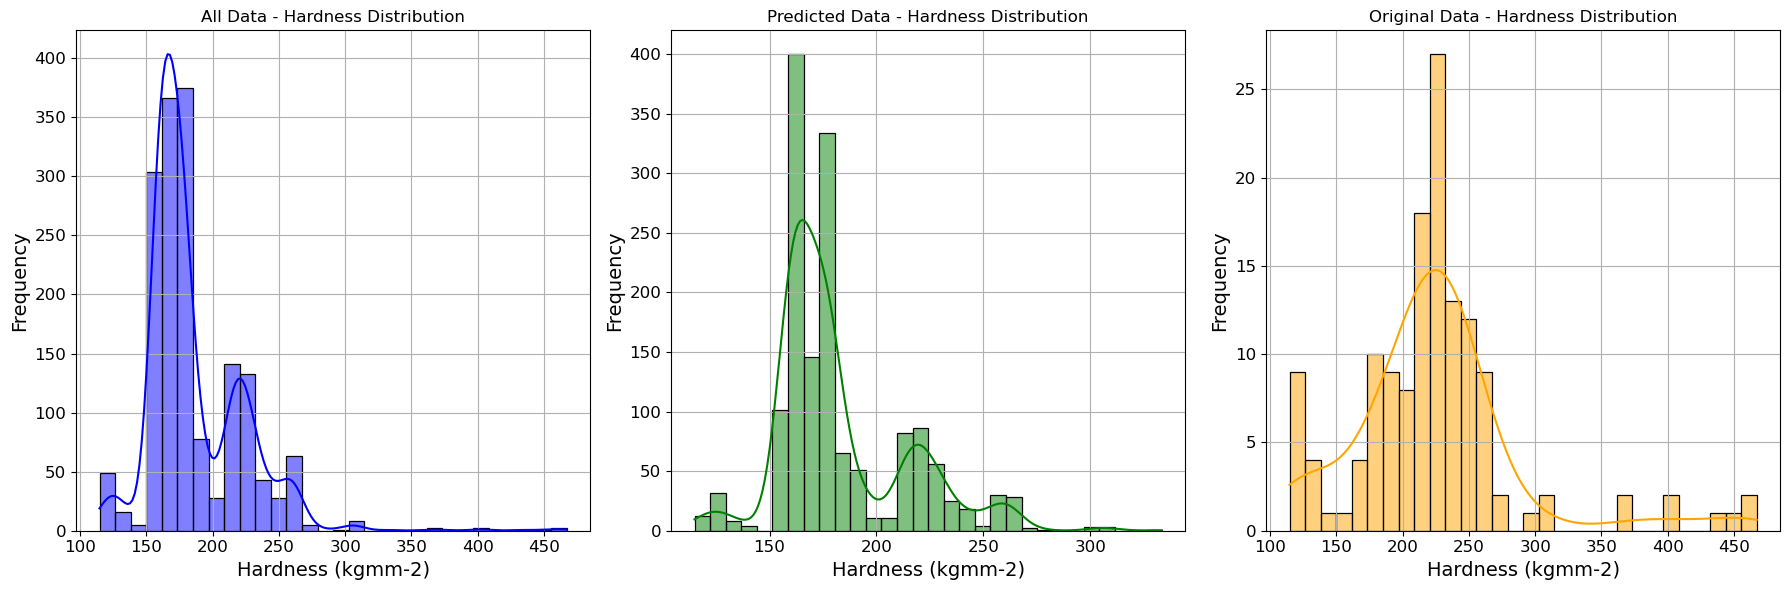

In [509]:
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Distribution of all data
sns.histplot(df_pred['Hardness (kgmm-2)'], bins=30, kde=True, color='blue', ax=axes[0])
axes[0].set_title('All Data - Hardness Distribution')
axes[0].set_xlabel('Hardness (kgmm-2)')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# Plot 2: Distribution of predicted data (Hardness Predicted = True)
sns.histplot(df_pred[df_pred['Hardness Predicted'] == True]['Hardness (kgmm-2)'], bins=30, kde=True, color='green', ax=axes[1])
axes[1].set_title('Predicted Data - Hardness Distribution')
axes[1].set_xlabel('Hardness (kgmm-2)')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)

# Plot 3: Distribution of originally provided data (Hardness Predicted = False)
sns.histplot(df_pred[df_pred['Hardness Predicted'] == False]['Hardness (kgmm-2)'], bins=30, kde=True, color='orange', ax=axes[2])
axes[2].set_title('Original Data - Hardness Distribution')
axes[2].set_xlabel('Hardness (kgmm-2)')
axes[2].set_ylabel('Frequency')
axes[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

The three plots compare the distribution of hardness values for the entire dataset, predicted data, and original labeled data. The **first plot** (All Data) shows a clear multimodal distribution, with the main peak around 170 kg/mm². The **second plot** (Predicted Data) follows the overall pattern closely but introduces more variation around the 200–250 kg/mm² range. In contrast, the **third plot** (Original Data) shows a wider spread with fewer data points, particularly in the higher hardness values (200–300 kg/mm²). Overall, the predictions help fill in the gaps and smoothen the distribution in the full dataset.